In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
sns.set_style('darkgrid')

from networkx.algorithms import bipartite



In [3]:
mafia = pd.read_csv('NDRANGHETAMAFIA_2M.csv')
mafia.head()

,Unnamed: 0,"18/10/2007(L), summit-dinner at ""la cadgrega"" restaurant in Limito di Pioltello (Mi)","29/11/2007(L), summit-dinner at ""la cadgrega"" restaurant in Limito di Pioltello (Mi)","02/02/2008(L), summit-dinner at ""Bar trattoria da Marina"" in S.Pietro all'Olmo, Cornaredo (Mi)","15/02/2008(1) meeting at ""The Sun” bar in San Vittore Olona",15/02/2008(2) dinner at Borgo Antico restaurant (Legnano),"21/02/2008(L), summit-dinner at ""da Rosario e Maria"" restaurant - Cornaredo (Mi)",'26/02/2008 dinner at “Il Palio” restaurant (Legnano),01/03/2008 new opening of “Cadrega” restaurant (Pioltello),"12/03/2008(L), “Ricottata” at “giardino degli ulivi” in Verano Brianza (MI)",...,"'23/05/2009, summit-dinner at “La Masseria” restaurant in Cisliano (Mi)",30/05/2009(?) summit at Cavenago Cambiago(mi),"18/06/2009(L), summit-dinner at pizzeria ""l'Antico Forno"" in Ceriano Laghetto (Mi)","26/06/2009(L), summit at ""Pesce Spada"" restaurant in Milan","11/07/2009 (L) summit at ""Flora Service Srl""","24/07/2009(L), summit (cencessione della dote a M.F.) at ""Old America"" pub - (Mi)","03/08/2009(L), summit at Novate Milanese's gardens","16/09/2009(?), summit at IMES Bollate(mi)",02/10/2009(?) summit at IMES- Bollate (mi),"'31/10/2009, summit at residential care “Falcone e Borsellino” in Paderno Dugnano (Mi)"
0,ALBANESE Giuseppe Domenico,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALVIANO Umberto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ANGHELONE Francesco,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,ARENA Carmelo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ARENA Salvatore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# the column names are inconvenient and inconsistent
# make a copy of the original dataset, and clean up the column names 
# use regex to just keep the dates of the meetings for now plus any brackets reference (1,2 etc)

mafia_copy = mafia.copy()
pattern = r'(\d{2}/\d{2}/\d{4}(\(\w\))?\w?)'
new_cols = mafia.columns[1:].str.extract(pattern).loc[:,0].values
cols_dict = {}
for i, col in enumerate(mafia.columns[1:]):
    cols_dict[col] = new_cols[i]
mafia = mafia.rename(columns = cols_dict)
mafia.head()

,Unnamed: 0,18/10/2007(L),29/11/2007(L),02/02/2008(L),15/02/2008(1),15/02/2008(2),21/02/2008(L),26/02/2008,01/03/2008,12/03/2008(L),...,23/05/2009,30/05/2009,18/06/2009(L),26/06/2009(L),11/07/2009,24/07/2009(L),03/08/2009(L),16/09/2009,02/10/2009,31/10/2009
0,ALBANESE Giuseppe Domenico,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALVIANO Umberto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ANGHELONE Francesco,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,ARENA Carmelo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ARENA Salvatore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**VISUALISING THE ATTENDENCE OF MEETINGS**



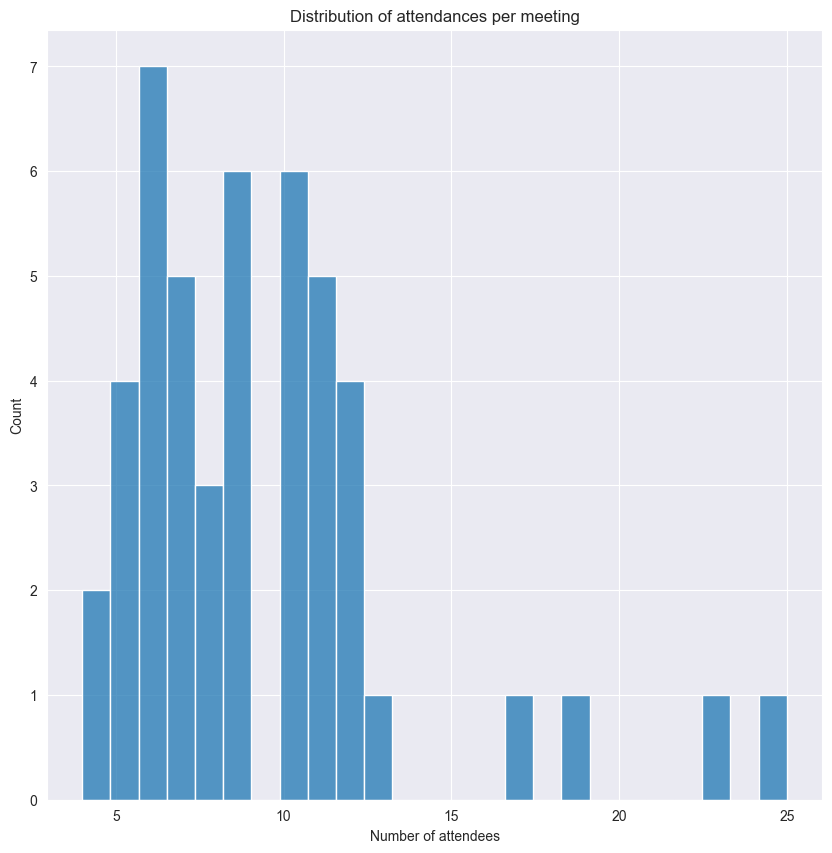

In [5]:
#visualise how many mafiosi typically attended each meeting
#meetings typically had 7-12 participants, a handful had significantly more

fig, ax = plt.subplots(figsize = (10, 10))
sns.histplot(mafia.sum()[1:], bins = 25, ax = ax)
plt.title('Distribution of attendances per meeting')
plt.xlabel('Number of attendees')
plt.show()

C:\Users\franc\AppData\Local\Temp\ipykernel_11052\730681783.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sns.histplot(mafia.sum(axis = 1)[1:], bins = 17, ax = ax)


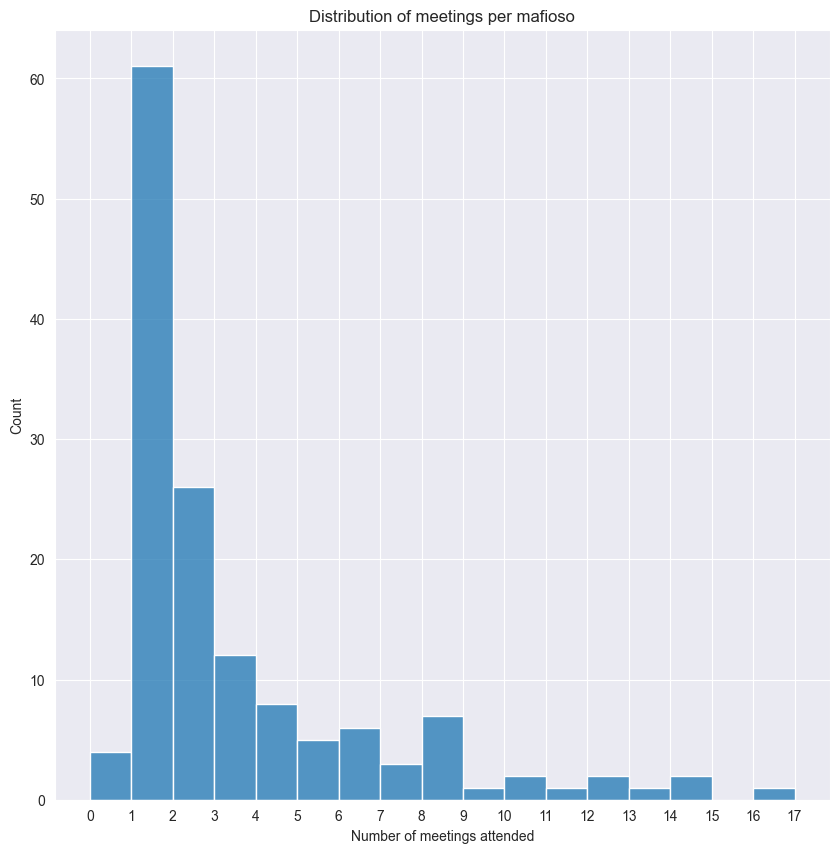

In [6]:
#visualise how many meetings each mafioso typically attended
#most mafiosi only attended one meeting, or perhaps two 
#a few attended a lot more

fig, ax = plt.subplots(figsize = (10, 10))
sns.histplot(mafia.sum(axis = 1)[1:], bins = 17, ax = ax)
plt.title('Distribution of meetings per mafioso')
plt.xticks(range(18))
plt.xlabel('Number of meetings attended')
plt.show()

In [7]:
mafia = mafia[mafia.sum(axis = 1) != 0].reset_index(drop = True)

C:\Users\franc\AppData\Local\Temp\ipykernel_11052\3988457360.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mafia = mafia[mafia.sum(axis = 1) != 0].reset_index(drop = True)


**CREATE A BIPARTITE NETWORK**

- Now that we have removed the five mafiosi who failed to make it to any meetings, it would be good to see if we can visualise the relationship more clearly between the mobsters and the meetings that they attended.
- We can do this by using NetworkX to create a bipartite network, with meetings in one group and mafiosi in the other.


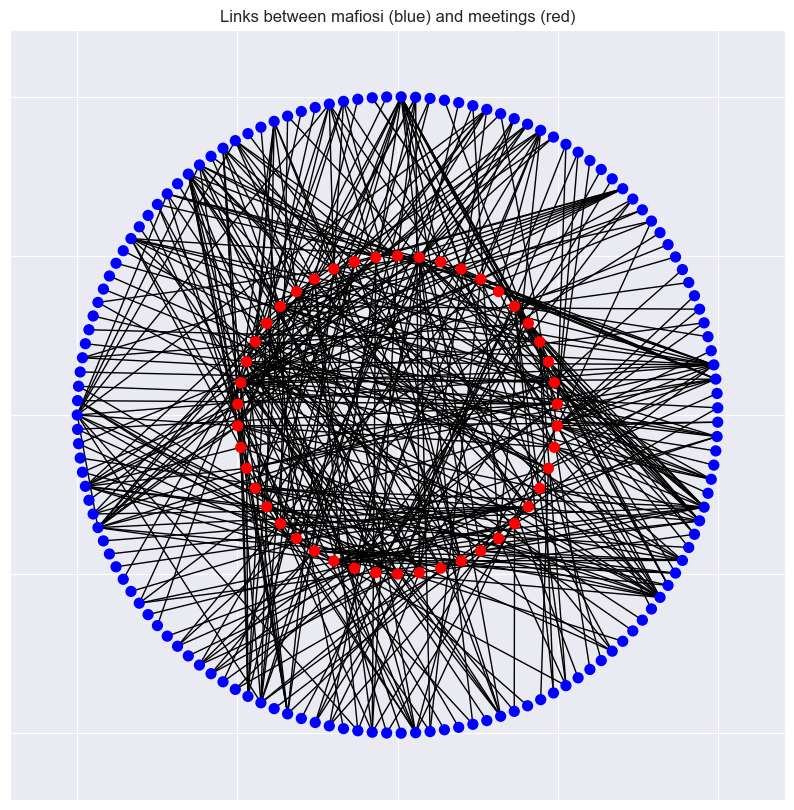

In [8]:
# create a bipartite network graph with NetworkX
B = nx.Graph()
B.add_nodes_from(list(mafia['Unnamed: 0'].index), bipartite = 0)
B.add_nodes_from(list(range(1000, (len(mafia.columns) -1) *1000, 1000)), bipartite = 1)


# separate lists for nodes representing meetings and mafiosi
top_nodes = [n for n, d in dict(B.nodes()).items() if d['bipartite'] == 0]
bottom_nodes = [n for n, d in dict(B.nodes()).items() if d['bipartite'] == 1]


# iterate through dataframe - where mafiosi has attended a specific meeting, add an 'edge' to a list of edges
B_edge_list = []
for i, row in mafia.iterrows():
    for j,col in enumerate(list(mafia.columns[1:])):
        if mafia.loc[i, col] == 1:
            edge = (i, j*1000)
            B_edge_list.append(edge)
B.add_edges_from(B_edge_list)


# plot the graph
shells = [list(bottom_nodes), list(top_nodes)]
positions = nx.shell_layout(B, shells)
fix, ax = plt.subplots(figsize = (10, 10))
plt.title('Links between mafiosi (blue) and meetings (red)')
nx.draw_networkx(B, pos = positions, ax = ax, with_labels = False, node_size = 50, node_color =  ['blue'] * len(top_nodes) + ['red'] * (len(bottom_nodes)))
plt.savefig('bipartite.png')

**VISUALISING THE RELATIONSHIPS BETWEEN MAFIOSI**
- The bipartite network has allowed us to visualise the relationship between mafiosi and meetings.
- An undirected graph will allow us to model the relationships between mafiosi and other mafiosi.
- First, there is some data-cleaning to be done, specifically around the names of the mafiosi.
- There are several challenges involved in cleaning up the names column from the dataset. Some mafiosi are referred to by only their first names. Some of them have double barrelled surnames (eg 'De Marco'). Some of them have a single christian name, others have two.
- To deal with this, it will be necessary to write four functions. The first will provied the mafioso with a fictitious surname ('X') if he doesn't already have one. This will enable a second function to extract the surname, a third to remove punctuation, and a fourth to extract christian name(s).


In [9]:
# function to add surname 'X' to characters with only a first name

def insert_surname(name):
    if len(name.split()) == 1:
        name = f'X_{name.split()[0]} ' + name 
    return name

In [10]:
# function to extract the surname (whether or not it is double-barrelled)

def extract_surname(name):
    if name.split()[1].upper() ==  name.split()[1]:
        return ' '.join(name.split()[:2])
    else:
        return name.split()[0]

In [11]:
# function to remove punctuation from surnames
import re

def clean_surname(name):
    new = re.sub(r'[^\w\s]', '', name)
    return new

In [12]:
# function to extract christian names
import re

def extract_christian_names(name):
    pattern = r'([A-Z][a-z]\w+)'
    name_list = re.findall(pattern, name)
    christian =  ' '.join(name_list)
    return christian

In [13]:
# create three new columns in the dataset, one for cleaned-up surnames, one for cleaned-up first names, and one for the two concatenated together

mafia['surnames'] = mafia['Unnamed: 0'].apply(insert_surname).apply(extract_surname).apply(clean_surname)
mafia['first_names'] = mafia['Unnamed: 0'].apply(extract_christian_names)
mafia['names'] =  mafia['surnames'] +' '+ mafia['first_names'] 

**EXTRACTING INFORMATION FROM THE DATASET TO BUILD DATAFRAME OF NODES AND EDGES FOR NETWORK ANALYSIS**

- The data is currently in the form of a sparse matrix. The rows are individual mafiosi, the columns are meetings, and the data is recorded as '1' for attendance and '0' for non-attendance.
- To conduct network analysis with NetworkX, we will need to convert this into nodes and edges which can be used for graphing. The nodes are simple, these are the mafiosi themselves. We can add an attribute to each node based on 'family_size', or how often the specific surname occurs within the data.
- The edges will require a bit of pre-processing. Each edge is a connection between two mafiosi, a connection occuring when they both attend the same meeting.
- To extract this information, we will transpose the dataframe, interate through the rows of meetings, and whenever a specific mafiosi has attended that meeting his name will be appended to a list within a default dictionary. The Combinations class from itertools allows us to iterate over those names, creating a new list of edges for each meeting. 


In [14]:
# create dataframe of weighted edges from raw data

from collections import defaultdict
from itertools import combinations


#copy and transpose dataframe
mafia_2 = mafia.copy()
#set the index to of dataframe to integer ids
mafia_2.index = range(len(mafia_2))
mafia_2.index = mafia_2.index.astype(int)

#mafia_2.index.name = None
mafia_2 = mafia_2.T


#create lists of attendees for each meeting and collect in dictionary
meetings = defaultdict(list)
for index, row in mafia_2.iterrows():
    for col in list(mafia_2.columns):
        if mafia_2.loc[index,col] == 1:
            meetings[index].append(col)
            
            
#create list of network edges from lists of attendees      
edges_list = []
for k, v in meetings.items():
    edges = list(combinations(v,2))
    edges_list.append(edges)

    
#flatten the list of lists and assemble in a dataframe
flat_edges_list = [item for sublist in edges_list for item in sublist]
# print the list flat_edges_list to see what it looks like



edges_df = pd.DataFrame(flat_edges_list, columns = ['source', 'target'])


#add weights to each edge, based on how often each mafiosi 'pairing' occured
weighted_edges_df = pd.DataFrame(edges_df.groupby(['source', 'target']).size().reset_index())
weighted_edges_df = weighted_edges_df.rename(columns = {0: 'weight'})
weighted_edges_df.head()



,source,target,weight
0,0,20,1
1,0,21,1
2,0,47,1
3,0,57,1
4,0,58,1


In [15]:
#to create a dataframe of nodes with 'family_size' attribute, we will need to first create a dictionary to map the 'family_size' onto each surname
family_sizes = mafia.groupby('surnames').size()
size_dict = defaultdict(int)
for name, size in family_sizes.items():
    size_dict[name] = size

# put mafiosi names into dataframe and add 'family_size' attribute
nodes_df = pd.DataFrame({'name': mafia['names'], 'surname': mafia['surnames']})
nodes_df['family_size'] = nodes_df['surname'].map(size_dict)
nodes_df.head()

,name,surname,family_size
0,ALBANESE Giuseppe Domenico,ALBANESE,1
1,ALVIANO Umberto,ALVIANO,1
2,ANGHELONE Francesco,ANGHELONE,1
3,ARENA Carmelo,ARENA,2
4,ARENA Salvatore,ARENA,2


**MANUALLY ADDED THE LOCAL AND THE ROLE OF EACH MAFISO**

Using the pre-trial detention order of "Operazione Infinito", the "locale" and "role" columns were added for each mafioso.
In addition, some suspects who appeared to be from outside the "N'drangheta" organization and had attended only one summit were removed.

In [17]:
#The resutling file of the manual data addition is imported here.
nodes_df=pd.read_csv('nodebis.csv')
#nodes_df.info()

In [18]:
#The various Calabrian "locali" that emerged from the investigation were merged as one local with the "Calabria"
nodes_df.loc[nodes_df['locale'].str.contains('Calabria'), 'locale'] = 'Calabria'
nodes_df[nodes_df['locale'].str.contains('Calabria')]

,surname,name,family_size,locale,ruolo
13,BELNOME,BELNOME Antonio,1,Calabria,Capo
19,BRUZZESE,BRUZZESE Carmelo,1,Calabria,Capo
31,COMMISSO,COMMISSO Giuseppe,2,Calabria,Membro Provincia
38,FARAO,FARAO Silvio,1,Calabria,Capo
41,FICARA,FICARA Domenico,2,Calabria,Capo
50,GALLACE,GALLACE Vincenzo,1,Calabria,Capo
81,MARINCOLA,MARINCOLA Cataldo,1,Calabria,Capo
99,OPPEDISANO,OPPEDISANO Michele,2,Calabria,Affiliato
100,OPPEDISANO,OPPEDISANO Pietro,2,Calabria,Affiliato
107,PELLE,PELLE Francesco,1,Calabria,Ex-capo


In [19]:
#add column of integer value for each locale
nodes_df['locale_id'] = nodes_df['locale'].astype('category').cat.codes
nodes_df.head()


,surname,name,family_size,locale,ruolo,locale_id
0,ALBANESE,ALBANESE Giuseppe Domenico,1,Cormano,Affiliato,5
1,ALVIANO,ALVIANO Umberto,1,Bresso,Affiliato,1
2,ANGHELONE,ANGHELONE Francesco,1,Bollate,Affiliato,0
3,ARENA,ARENA Carmelo,2,Legnano,Affiliato,8
4,ARENA,ARENA Salvatore,2,Rho,Affiliato,14


In [20]:
#count the number of mafiosi for each ruolo
nodes_df['ruolo'].value_counts()

Affiliato               102
Capo                     19
Vicario                   6
Contabile                 5
Politico                  2
Ex-capo                   2
Membro Provincia          1
Capo Generale             1
Agenzia Delle Dogane      1
Name: ruolo, dtype: int64

In [21]:
nodes_df['locale'].value_counts()

Cormano            21
Pioltello          19
Bresso             18
Bollate            15
Milano             14
Calabria           13
Legnano             7
Rho                 5
Desio               5
Mariano Comense     5
Solaro              4
Cittadino           3
Pavia               3
Corsico             3
Lombardia           2
Canzo               2
Name: locale, dtype: int64

In [37]:
#export nodes_df to csv
nodes_df.to_csv('nodes.csv', index = False)
weighted_edges_df.to_csv('edges.csv', index = False)